In [1]:
# Import libraries
import numpy as np
import cv2
from PIL import Image, ImageOps
import numpy as np
import jovian
import keras
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

[jovian] Update Available: 0.2.15 --> 0.2.16
[jovian] Run `!pip install jovian --upgrade` to upgrade


Using TensorFlow backend.


#### You need not run Keras model, I have trained and saved the trained model. 
#### Directly go to `Testing on Real world` cell and run from there.

### Note:
* You can download Face Mask dataset from here https://github.com/prajnasb/face_detector/tree/master/dataset

## Traing Keras Model 

In [1]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

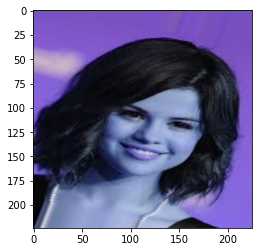

In [11]:
img = cv2.imread('./face2.jpg')
plt.imshow(image_gen.random_transform(img))

In [12]:
image_gen.flow_from_directory('./dataset/test')

Found 245 images belonging to 2 classes.


In [13]:
image_gen.flow_from_directory('./dataset/train')

Found 1131 images belonging to 2 classes.


In [14]:
image_shape = (150,150,3)

In [15]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary, 0=cat , 1=dog
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [16]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('./dataset/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')
test_image_gen = image_gen.flow_from_directory('./dataset/test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 1131 images belonging to 2 classes.
Found 245 images belonging to 2 classes.


In [17]:
train_image_gen.class_indices

{'with_mask': 0, 'without_mask': 1}

In [18]:
import warnings
import PIL.Image
warnings.filterwarnings('ignore')

In [19]:
results = model.fit_generator(train_image_gen,epochs=5,
                              steps_per_epoch=150,
                              validation_data=test_image_gen,validation_steps=12)

Epoch 1/5
150/150 [==============================] - 86s 576ms/step - loss: 0.2909 - accuracy: 0.8854 - val_loss: 0.1376 - val_accuracy: 0.9375
Epoch 2/5
150/150 [==============================] - 74s 491ms/step - loss: 0.1305 - accuracy: 0.9623 - val_loss: 0.0081 - val_accuracy: 0.9890
Epoch 3/5
150/150 [==============================] - 74s 490ms/step - loss: 0.1004 - accuracy: 0.9657 - val_loss: 0.0671 - val_accuracy: 0.9669
Epoch 4/5
150/150 [==============================] - 73s 484ms/step - loss: 0.1042 - accuracy: 0.9648 - val_loss: 0.1515 - val_accuracy: 0.9669
Epoch 5/5
150/150 [==============================] - 73s 487ms/step - loss: 0.1072 - accuracy: 0.9665 - val_loss: 0.0029 - val_accuracy: 0.9792


In [23]:
predictions = model.predict_generator(test_image_gen,steps=70)

In [24]:
predictions

array([[8.7532657e-01],
       [2.2835458e-07],
       [9.7867811e-01],
       ...,
       [6.5019496e-02],
       [9.2428303e-01],
       [4.4626873e-07]], dtype=float32)

In [ ]:
import numpy as np
from keras.preprocessing import image
import glob
for i in glob.glob('./dataset/test/without_mask/*'):

    img = image.load_img(i, target_size=(150, 150))

    img = image.img_to_array(img)

    # dog_img = np.array(dog_img)
    img = img/255
    prediction_prob = model.predict_classes(img.reshape(1,150,150,3))
    print(prediction_prob)

In [32]:
model.save('keras_facemask_0906.h5')

## Testing on Real World

In [2]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
model = load_model('./saved models/keras_facemask_0906.h5')

In [3]:
def predicition():
    img = './face.jpg'
    img = image.load_img(img, target_size=(150, 150))
    img = image.img_to_array(img)
    img = img/255
    
    prediction = model.predict_classes(img.reshape(1,150,150,3))
    for i in prediction:
        if(i==1):
            return('With Mask',(0,255,0))
        else:
            return('Without Mask',(0,0,255))

## Using HaarCascade

In [ ]:
import cv2
from PIL import Image
import time

face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'XVID') 
out = cv2.VideoWriter('./outputs/output1.avi', -1, 20.0, (640, 480)) 
fps = 25
while True:
    ret, frame = cap.read()
    if ret==True:
        frame_bgr = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        face_location = face_cascade.detectMultiScale(frame_bgr,scaleFactor = 1.3,minNeighbors = 4)
        time.sleep(1/fps)
        if(face_location!=[]):
            for x,y,w,h in face_location:

                roi = frame[y: y+h, x: x+w]
                roi_img = Image.fromarray(roi, 'RGB')
                roi_img.save('face.jpg')
                result,color = predicition()

                if(result=='With Mask'):
                    cv2.putText(frame, result, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 2)
                    cv2.rectangle(frame, (x,y),(x+w,y+h), color, 2)     
                else:
                    cv2.putText(frame, result, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 2)
                    cv2.rectangle(frame, (x,y),(x+w,y+h), color, 2)
                        
        cv2.imshow("Frame", frame)
        out.write(frame)  
        if cv2.waitKey(1) == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

c:\users\vsneh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


In [1]:
import jovian

<IPython.core.display.Javascript object>

In [2]:
jovian.commit(environment='none')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


[jovian] Error: Failed to detect notebook filename. Please provide the correct notebook filename as the "filename" argument to "jovian.commit".
